# ArangoDB 🥑 + LangChain 🦜🔗 + LlamaIndex 🦙 (Full)

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arangodb/interactive_tutorials/blob/master/notebooks/Langchain.ipynb)

Large language models (LLMs) ~are emerging~ have emerged as a transformative technology, enabling developers to build applications that they previously could not. However, using these LLMs in isolation is often insufficient for creating a truly powerful app - the real power comes when you can combine them with other sources of computation or knowledge.

This notebook will leverage LLMs to provide a natural language interface to querying ArangoDB.

**Please note**: We'll be using **OpenAI via LangChain & LlamaIndex**, which requires you to have a **paid** [OpenAI API Key](https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key). Other Chat Models are available as well, e.g see:
- https://github.com/langchain-ai/langchain/tree/master/libs/langchain/langchain/chat_models
- https://docs.llamaindex.ai/en/stable/module_guides/models/llms.html

In [1]:
%%capture

# Set your OpenAI API Key
# https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key

!pip install openai==1.13.3

!pip install langchain==0.1.11
!pip install langchain-community==0.0.27

!pip install llama-index==0.10.18
!pip install llama-index-readers-arango-db==0.1.3

In [2]:
import os

os.environ["OPENAI_API_KEY"] = "sk-..."

#### Table of Contents

1. [LangChain 101](#scrollTo=3)
2. [Setup](#scrollTo=17)
3. [Prompting](#scrollTo=34)
4. [Prompt Engineering](#scrollTo=77)
5. [Fine-Tuning](#scrollTo=95)
6. [LlamaIndex 101](#scrollTo=106)

## LangChain 101 🦜🔗

> [LangChain](https://www.langchain.com/) is a framework for developing applications powered by language models. It enables applications that are:
- Data-aware: connect a language model to other sources of data
- Agentic: allow a language model to interact with its environment

[Source](https://python.langchain.com/docs/get_started/introduction)

There are six basic components of Langchain:
- **Models**: the library of LLMs to choose from
- **Prompts**: text that guides the LLM to generate the desired output
- **Chains**: sequences of instructions the LangChain framework executes to perform a task
- **Memory**: a method of storing data for the LLM to access later
- **Agents & Tools**: the essential components to perform specific tasks based on user context
- **Indexes, Vectorstores, & Retrievers**: the essential components to building an app on your specific data

In [3]:
# 1. Install dependencies

%%capture
!pip install wikipedia==1.4.0
!pip install sentence_transformers==2.2.2
!pip install faiss-cpu==1.7.4
!pip install chromadb==0.4.15
!pip install tiktoken==0.5.1

In [4]:
# 2. Basic Prompting

from langchain.llms import OpenAI

model = OpenAI(temperature=0)

print(model("What is ArangoDB?"))

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.openai.OpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




ArangoDB is a multi-model, open-source database management system that allows users to store, query, and manipulate data using a variety of data models, including document, graph, and key-value. It is designed to be highly scalable, fault-tolerant, and efficient, making it suitable for a wide range of use cases, from small-scale applications to large-scale enterprise systems. ArangoDB also offers a flexible query language, AQL, which allows users to perform complex queries across different data models. It is available for use on-premises or in the cloud.


In [5]:
# 3. Prompting with Templates

from langchain import PromptTemplate

template = """
  Question: {question}
  Explain like I'm five!
"""

prompt = PromptTemplate(template=template, input_variables=["question"])

print(model(prompt.format(question="What is ArangoDB?")))


ArangoDB is like a big box of toys that can store lots of different things, like your toys, your books, and your snacks. But it's not just a box, it's also a magic box that can help you find and organize your toys and books whenever you want. And the best part is, you can share your toys and books with your friends and they can share theirs with you too!


In [6]:
# 4. Prompting with Chains

from langchain import LLMChain

chain = LLMChain(prompt=prompt, llm=model)

question = "What is ArangoDB?"

print(chain.invoke(question))

{'question': 'What is ArangoDB?', 'text': "\nArangoDB is like a big box of toys that can store lots of different things, like your toys, your books, and your snacks. But it's not just a box, it's also a magic box that can help you find and organize your toys and books whenever you want. And the best part is, you can share your toys and books with your friends and they can share theirs with you too!"}


In [7]:
# 5. Prompting with Memory

from langchain import OpenAI, ConversationChain

model = OpenAI(temperature=0)

conversation = ConversationChain(llm=model, verbose=True)

conversation.predict(input="How old is C++?")
conversation.predict(input="Sorry I meant ArangoDB")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: How old is C++?
AI:

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: How old is C++?
AI:  C++ was first developed in 1983 by Bjarne Stroustrup at Bell Labs. However, it wasn't officially released until 1985. So, depending on how you define its age, it could be anywhere from 36 to 38 years old.
Human: Sorry I meant ArangoDB
AI:

> Finished chain.


' No problem! ArangoDB was first released in 2012, making it about 9 years old. It was created by the company ArangoDB GmbH and is currently on version 3.7.11.'

In [8]:
# 6. Prompting via Agent

from langchain.agents import load_tools
from langchain.agents import initialize_agent

model = OpenAI(temperature=0)

tools = load_tools(["wikipedia", "llm-math"], llm=model)

agent = initialize_agent(tools, model, agent="zero-shot-react-description", verbose=True)

agent.invoke("What is 2 + 2")
agent.invoke("How old is ArangoDB?")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(




> Entering new AgentExecutor chain...
 I should use the calculator to solve this math problem
Action: Calculator
Action Input: 2 + 2
Observation: Answer: 4
Thought: I now know the final answer
Final Answer: 4

> Finished chain.


> Entering new AgentExecutor chain...
 I should use Wikipedia to find information about ArangoDB
Action: Wikipedia
Action Input: ArangoDB
Observation: Wikipedia is not a valid tool, try one of [wikipedia, Calculator].
Thought: I should use Calculator to find the age of ArangoDB
Action: Calculator
Action Input: 2021 - 2012
Observation: Answer: 9
Thought: I now know the final answer
Final Answer: ArangoDB is 9 years old.

> Finished chain.


{'input': 'How old is ArangoDB?', 'output': 'ArangoDB is 9 years old.'}

In [9]:
# 7. Prompting with Indexes (1): Data Load

# Using ChromaDB & LangChain to perform question answering over documents.

from langchain.document_loaders import TextLoader
import requests

# Fetch some sample data
url = "https://raw.githubusercontent.com/hwchase17/chroma-langchain/master/state_of_the_union.txt"
res = requests.get(url)

with open("state_of_the_union.txt", "w") as f:
  f.write(res.text)

# Load documents
loader = TextLoader('state_of_the_union.txt')
documents = loader.load()

len(documents)

1

In [10]:
# 7. Prompting with Indexes (2): Text Splitting

# Next: splitting documents into small chunks.
# This is so we can find the most relevant chunks
# for a query and pass only those into the LLM.

from langchain.text_splitter import RecursiveCharacterTextSplitter

# Text Splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

len(texts)

42

In [11]:
# 7. Prompting with Indexes (3): Initialize PeristedChromaDB

# Create embeddings for each chunk and insert
# into the Chroma vector database.
# The persist_directory argument tells ChromaDB
# where to store the database when it's persisted.

from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

# Embed and store the texts
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=texts, embedding=embedding)

vectordb

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [12]:
# 7. Prompting with Indexes (5): Create the chain
from langchain.chains.retrieval_qa.base import VectorDBQA

chain = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=vectordb)

/usr/local/lib/python3.10/dist-packages/langchain/chains/retrieval_qa/base.py:256: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(


In [13]:
# 7. Prompting with Indexes (6): Asking questions

print(chain.invoke("TL;DR the president's message for me"))
print('-'*100)
print(chain.invoke("What did the president say specifically about Russian oligarchs?"))
print('-'*100)
print(chain.invoke("How much did the President say the economy grew last year?"))

{'query': "TL;DR the president's message for me", 'result': " The president's message is that the State of the Union is strong because the American people are strong. We have overcome challenges and will continue to do so as one united nation. The president highlights the bravery and determination of the Ukrainian people and the strength of our democracy. He also mentions his optimism for the future of America and the need for unity to address issues such as the opioid epidemic and the protection of LGBTQ+ rights."}
----------------------------------------------------------------------------------------------------
{'query': 'What did the president say specifically about Russian oligarchs?', 'result': ' The president said that the U.S. Department of Justice is assembling a task force to go after the crimes of Russian oligarchs and that they are joining with European allies to find and seize their assets, such as yachts, luxury apartments, and private jets.'}
---------------------------

- Question-Answering in LangChain: https://python.langchain.com/docs/use_cases/question_answering/
- Integrations in LangChain: https://python.langchain.com/docs/integrations/providers

---
## Setup

### Preliminaries

In [14]:
%%capture

# 1: Install the dependencies

!pip install python-arango # The ArangoDB Python Driver
!pip install adb-cloud-connector # The ArangoDB Cloud Instance provisioner
!pip install arango-datasets # Datasets package

In [15]:
# 2. Helper Function Definitions

import json

def pprint(data):
  print(json.dumps(data, indent=4))

def query(db, aql):
  pprint(list(db.aql.execute(aql)))

In [16]:
# 3. Provisioning ArangoDB

from adb_cloud_connector import get_temp_credentials

credentials = get_temp_credentials(tutorialName="LangChain")

pprint(credentials)

Log: requesting new credentials...
Succcess: new credentials acquired
{
    "dbName": "TUT0ftdwtjk1k8r6ylosouevgm",
    "username": "TUTmac2xjlpoqtdt8869ajywp",
    "password": "TUTshqo73vc3pqz9m6wcsjqd",
    "hostname": "tutorials.arangodb.cloud",
    "port": 8529,
    "url": "https://tutorials.arangodb.cloud:8529"
}


In [17]:
# 4. Connecting to ArangoDB

from arango import ArangoClient

client = ArangoClient(credentials["url"], request_timeout=None)

db = client.db(
    name=credentials["dbName"],
    username=credentials["username"],
    password=credentials["password"],
    verify=True
)

db

<StandardDatabase TUT0ftdwtjk1k8r6ylosouevgm>

### Loading Datasets

#### Game Of Thrones

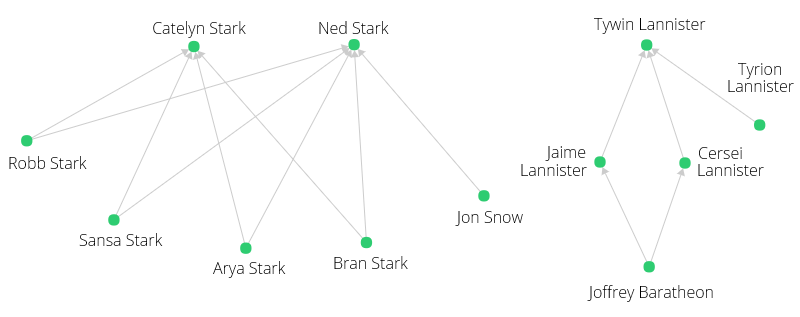

In [18]:
# (13 nodes, 15 edges)
# This dataset represents the parent-child
# relationships of certain characters from the GoT universe

from arango_datasets import Datasets

Datasets(db).load("GAME_OF_THRONES")

Output()

Output()

Output()

Initializing collection 'ChildOf'


Output()

Output()

#### GDELT Project (Open Intelligence)

> GDELT monitors the world's news media from nearly every corner of every country
in print, broadcast, and web formats, in over 100 languages,
every moment of every day. [...] Put simply, the GDELT Project is a realtime open data global graph over human society as seen through the eyes of the world's news media, reaching deeply into local events, reaction, discourse, and emotions of the most remote corners of the world in near-realtime and making all of this available as an open data firehose to enable research over human society.


In [19]:
# (~70k nodes, ~400k edges)
# https://www.gdeltproject.org/

from arango_datasets import Datasets

Datasets(db).load("OPEN_INTELLIGENCE")

Output()

Output()

Initializing collection 'Actor'


Output()

Initializing collection 'Class'


Output()

Output()

Output()

Initializing collection 'Country'


Output()

Output()

Initializing collection 'Event'


Output()

Output()

Initializing collection 'Location'


Output()

Output()

Initializing collection 'Region'


Output()

Output()

Initializing collection 'Source'


Output()

Output()

Initializing collection 'eventActor'


Output()

Initializing collection 'hasLocation'


Output()

Output()

Output()

Initializing collection 'hasSource'


Output()

Output()

Initializing collection 'inCountry'


Output()

Output()

Initializing collection 'inRegion'


Output()

Output()

Initializing collection 'subClass'


Output()

Output()

Initializing collection 'type'


Output()

### Configuring LangChain

In [20]:
# 1: Instantiate the ArangoDB-LangChain Graph wrapper

from langchain.graphs import ArangoGraph

graph = ArangoGraph(db)

pprint(graph.schema)

{
    "Graph Schema": [
        {
            "graph_name": "GAME_OF_THRONES",
            "edge_definitions": [
                {
                    "edge_collection": "ChildOf",
                    "from_vertex_collections": [
                        "Characters"
                    ],
                    "to_vertex_collections": [
                        "Characters"
                    ]
                }
            ]
        },
        {
            "graph_name": "OPEN_INTELLIGENCE",
            "edge_definitions": [
                {
                    "edge_collection": "eventActor",
                    "from_vertex_collections": [
                        "Event"
                    ],
                    "to_vertex_collections": [
                        "Actor"
                    ]
                },
                {
                    "edge_collection": "hasLocation",
                    "from_vertex_collections": [
                        "Event"
                    ],

In [21]:
# 2: Instantiate the OpenAI Chat model
# Note that other models can be used as well
# Ref: https://github.com/langchain-ai/langchain/tree/master/libs/langchain/langchain/chat_models

from langchain.chat_models import ChatOpenAI

model = ChatOpenAI(temperature=0, model_name='gpt-4')

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [22]:
# 3: Instantiate the LangChain Question-Answering Chain with
# our **model** and **graph**

from langchain.chains import ArangoGraphQAChain

chain = ArangoGraphQAChain.from_llm(model, graph=graph, verbose=True)

---
## Prompting

#### Game Of Thrones

In [23]:
chain.invoke("Who are the 2 youngest characters?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters
FOR c IN Characters
SORT c.age ASC
LIMIT 2
RETURN c

AQL Result:
[{'_key': 'BranStark', '_id': 'Characters/BranStark', '_rev': '_hg5hjBG--D', 'name': 'Bran', 'surname': 'Stark', 'alive': True, 'age': 10, 'gender': 'male'}, {'_key': 'AryaStark', '_id': 'Characters/AryaStark', '_rev': '_hg5hjBG--C', 'name': 'Arya', 'surname': 'Stark', 'alive': True, 'age': 11, 'gender': 'female'}]

> Finished chain.


{'query': 'Who are the 2 youngest characters?',
 'result': 'The two youngest characters are Bran Stark, who is 10 years old, and Arya Stark, who is 11 years old.'}

In [24]:
chain.invoke("How are Bran Stark and Arya Stark related?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..10 ANY 'Characters/BranStark' ChildOf
  FILTER v._key == 'AryaStark'
  RETURN e

AQL Result:
[{'_key': '267270127', '_id': 'ChildOf/267270127', '_from': 'Characters/AryaStark', '_to': 'Characters/NedStark', '_rev': '_hg5hliC--A'}, {'_key': '267270129', '_id': 'ChildOf/267270129', '_from': 'Characters/AryaStark', '_to': 'Characters/CatelynStark', '_rev': '_hg5hliC--B'}, {'_key': '267270127', '_id': 'ChildOf/267270127', '_from': 'Characters/AryaStark', '_to': 'Characters/NedStark', '_rev': '_hg5hliC--A'}, {'_key': '267270129', '_id': 'ChildOf/267270129', '_from': 'Characters/AryaStark', '_to': 'Characters/CatelynStark', '_rev': '_hg5hliC--B'}, {'_key': '267270129', '_id': 'ChildOf/267270129', '_from': 'Characters/AryaStark', '_to': 'Characters/CatelynStark', '_rev': '_hg5hliC--B'}, {'_key': '267270127', '_id': 'ChildOf/267270127', '_from': 'Characters/AryaStark', '_to': 'Characters/NedStar

{'query': 'How are Bran Stark and Arya Stark related?',
 'result': 'Bran Stark and Arya Stark are related as siblings. They both are the children of Ned Stark and Catelyn Stark.'}

In [25]:
chain.invoke("Who are Bran Stark’s grandparents?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 2..2 OUTBOUND 'Characters/BranStark' ChildOf
RETURN v

AQL Result:
[{'_key': 'LyarraStark', '_id': 'Characters/LyarraStark', '_rev': '_hg5hjBG--_', 'name': 'Lyarra', 'surname': 'Stark', 'alive': False, 'age': 60, 'gender': 'female'}, {'_key': 'RickardStark', '_id': 'Characters/RickardStark', '_rev': '_hg5hjBG---', 'name': 'Rickard', 'surname': 'Stark', 'alive': False, 'age': 60, 'gender': 'male'}]

> Finished chain.


{'query': 'Who are Bran Stark’s grandparents?',
 'result': "Bran Stark's grandparents are Lyarra Stark and Rickard Stark."}

In [26]:
chain.invoke("Fetch me the character count for each family")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR doc IN Characters
    COLLECT family = doc.surname WITH COUNT INTO characterCount
    RETURN {family: family, characterCount: characterCount}

AQL Result:
[{'family': 'Baratheon', 'characterCount': 1}, {'family': 'Lannister', 'characterCount': 4}, {'family': 'Stark', 'characterCount': 8}]

> Finished chain.


{'query': 'Fetch me the character count for each family',
 'result': 'The count of characters for each family in the database is as follows: There is 1 character from the Baratheon family, 4 characters from the Lannister family, and 8 characters from the Stark family.'}

In [27]:
chain.invoke("What is the age difference between Rickard Stark and Arya Stark?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters
FOR rickard IN Characters
    FILTER rickard._key == 'RickardStark'
FOR arya IN Characters
    FILTER arya._key == 'AryaStark'
RETURN ABS(rickard.age - arya.age)

AQL Result:
[49]

> Finished chain.


{'query': 'What is the age difference between Rickard Stark and Arya Stark?',
 'result': 'The age difference between Rickard Stark and Arya Stark is 49 years.'}

In [28]:
chain.invoke("Wie alt ist Rickard Stark?") # (German: "How old is Rickard Stark?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters
FOR character IN Characters
    FILTER character.name == 'Rickard' AND character.surname == 'Stark'
    RETURN character.age

AQL Result:
[60]

> Finished chain.


{'query': 'Wie alt ist Rickard Stark?',
 'result': 'Rickard Stark was 60 years old.'}

In [95]:
chain.invoke("Fetch me the average age of all Stark characters")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters
RETURN AVERAGE(
  FOR character IN Characters
    FILTER CONTAINS(character._key, 'Stark')
    RETURN character.age
)

AQL Result:
[31.375]

> Finished chain.


{'query': 'Fetch me the average age of all Stark characters',
 'result': 'The average age of all Stark characters in the database is approximately 31.4 years.',
 'aql_query': "\nWITH Characters\nRETURN AVERAGE(\n  FOR character IN Characters\n    FILTER CONTAINS(character._key, 'Stark')\n    RETURN character.age\n)\n",
 'aql_result': [31.375]}

In [30]:
chain.invoke("Does Bran Stark have a dead parent?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..1 OUTBOUND 'Characters/BranStark' ChildOf
FILTER v.alive == false
RETURN v

AQL Result:
[{'_key': 'CatelynStark', '_id': 'Characters/CatelynStark', '_rev': '_hg5hjBG--B', 'name': 'Catelyn', 'surname': 'Stark', 'alive': False, 'age': 40, 'gender': 'female'}]

> Finished chain.


{'query': 'Does Bran Stark have a dead parent?',
 'result': 'Yes, Bran Stark has a dead parent. His mother, Catelyn Stark, is deceased.'}

In [31]:
chain.invoke("Add Jon Snow, 31, a male character. Use overwrite.")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters
INSERT { "_key": "JonSnow", "name": "Jon", "surname": "Snow", "alive": true, "age": 31, "gender": "male" } INTO Characters OPTIONS { overwrite: true }

AQL Result:
[]

> Finished chain.


{'query': 'Add Jon Snow, 31, a male character. Use overwrite.',
 'result': 'The character Jon Snow, a 31-year-old male, has been successfully added to the database. If there was a previous entry for Jon Snow, it has been overwritten with the new information.'}

In [32]:
chain.invoke("Create a ChildOf edge from Jon Snow to Ned Stark.")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
INSERT {
  _from: "Characters/JonSnow",
  _to: "Characters/NedStark"
} INTO ChildOf

AQL Result:
[]

> Finished chain.


{'query': 'Create a ChildOf edge from Jon Snow to Ned Stark.',
 'result': 'A relationship has been established in the database indicating that Jon Snow is a child of Ned Stark.'}

In [33]:
chain.invoke("Who is related to Ned Stark?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..1 ANY 'Characters/NedStark' ChildOf
RETURN v

AQL Result:
[{'_key': 'JonSnow', '_id': 'Characters/JonSnow', '_rev': '_hg5i5Yu--_', 'name': 'Jon', 'surname': 'Snow', 'alive': True, 'age': 31, 'gender': 'male'}, {'_key': 'AryaStark', '_id': 'Characters/AryaStark', '_rev': '_hg5hjBG--C', 'name': 'Arya', 'surname': 'Stark', 'alive': True, 'age': 11, 'gender': 'female'}, {'_key': 'SansaStark', '_id': 'Characters/SansaStark', '_rev': '_hg5hjBG--G', 'name': 'Sansa', 'surname': 'Stark', 'alive': True, 'age': 13, 'gender': 'female'}, {'_key': 'RobbStark', '_id': 'Characters/RobbStark', '_rev': '_hg5hjBG--F', 'name': 'Robb', 'surname': 'Stark', 'alive': False, 'age': 16, 'gender': 'male'}, {'_key': 'BranStark', '_id': 'Characters/BranStark', '_rev': '_hg5hjBG--D', 'name': 'Bran', 'surname': 'Stark', 'alive': True, 'age': 10, 'gender': 'male'}, {'_key': 'LyarraStark', '_id': 'Characters/LyarraStark

{'query': 'Who is related to Ned Stark?',
 'result': "Ned Stark is related to several characters. His children are Jon Snow, Arya Stark, Sansa Stark, Robb Stark, and Bran Stark. Jon Snow is 31 years old and is alive. Arya Stark is 11 years old and is also alive. Sansa Stark is 13 years old and is alive. Robb Stark was 16 years old but is now deceased. Bran Stark is 10 years old and is alive. Ned Stark's parents are Lyarra Stark and Rickard Stark. Lyarra Stark was 60 years old but is now deceased. Rickard Stark was also 60 years old but is now deceased."}

In [34]:
chain.invoke("What can you tell me about the characters?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters
FOR character IN Characters
RETURN character

AQL Result:
[{'_key': 'RickardStark', '_id': 'Characters/RickardStark', '_rev': '_hg5hjBG---', 'name': 'Rickard', 'surname': 'Stark', 'alive': False, 'age': 60, 'gender': 'male'}, {'_key': 'LyarraStark', '_id': 'Characters/LyarraStark', '_rev': '_hg5hjBG--_', 'name': 'Lyarra', 'surname': 'Stark', 'alive': False, 'age': 60, 'gender': 'female'}, {'_key': 'NedStark', '_id': 'Characters/NedStark', '_rev': '_hg5hjBG--A', 'name': 'Ned', 'surname': 'Stark', 'alive': True, 'age': 41, 'gender': 'male'}, {'_key': 'CatelynStark', '_id': 'Characters/CatelynStark', '_rev': '_hg5hjBG--B', 'name': 'Catelyn', 'surname': 'Stark', 'alive': False, 'age': 40, 'gender': 'female'}, {'_key': 'AryaStark', '_id': 'Characters/AryaStark', '_rev': '_hg5hjBG--C', 'name': 'Arya', 'surname': 'Stark', 'alive': True, 'age': 11, 'gender': 'female'}, {'_key': 'BranStark', '_id': 'Characters/BranStark

{'query': 'What can you tell me about the characters?',
 'result': 'The database contains information about several characters. Here are some of them:\n\n1. Rickard Stark: He is a male character who is not alive. He was 60 years old.\n2. Lyarra Stark: She is a female character who is not alive. She was 60 years old.\n3. Ned Stark: He is a male character who is alive. He is 41 years old.\n4. Catelyn Stark: She is a female character who is not alive. She was 40 years old.\n5. Arya Stark: She is a female character who is alive. She is 11 years old.\n6. Bran Stark: He is a male character who is alive. He is 10 years old.\n7. Robb Stark: He is a male character who is not alive. He was 16 years old.\n8. Sansa Stark: She is a female character who is alive. She is 13 years old.\n9. Tywin Lannister: He is a male character who is not alive. He was 67 years old.\n10. Jaime Lannister: He is a male character who is alive. He is 36 years old.'}

In [35]:
chain.invoke("Use the shortest path algorithm to go from Bran Stark to Rickard Stark")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN OUTBOUND SHORTEST_PATH 'Characters/BranStark' TO 'Characters/RickardStark' GRAPH 'GAME_OF_THRONES'
RETURN {vertex: v, edge: e}

AQL Result:
[{'vertex': {'_key': 'BranStark', '_id': 'Characters/BranStark', '_rev': '_hg5hjBG--D', 'name': 'Bran', 'surname': 'Stark', 'alive': True, 'age': 10, 'gender': 'male'}, 'edge': None}, {'vertex': {'_key': 'NedStark', '_id': 'Characters/NedStark', '_rev': '_hg5hjBG--A', 'name': 'Ned', 'surname': 'Stark', 'alive': True, 'age': 41, 'gender': 'male'}, 'edge': {'_key': '267270121', '_id': 'ChildOf/267270121', '_from': 'Characters/BranStark', '_to': 'Characters/NedStark', '_rev': '_hg5hli----'}}, {'vertex': {'_key': 'RickardStark', '_id': 'Characters/RickardStark', '_rev': '_hg5hjBG---', 'name': 'Rickard', 'surname': 'Stark', 'alive': False, 'age': 60, 'gender': 'male'}, 'edge': {'_key': '267270137', '_id': 'ChildOf/267270137', '_from': 'Characters/NedStark', 

{'query': 'Use the shortest path algorithm to go from Bran Stark to Rickard Stark',
 'result': 'The shortest path from Bran Stark to Rickard Stark in the Game of Thrones graph goes through Ned Stark. Bran Stark, who is alive and 10 years old, is the son of Ned Stark, who is also alive and 41 years old. Ned Stark is the son of Rickard Stark, who is not alive and was 60 years old.'}

In [36]:
chain.invoke("What is the family tree of Joffrey Baratheon?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..100 OUTBOUND 'Characters/JoffreyBaratheon' ChildOf
RETURN v

AQL Result:
[{'_key': 'JaimeLannister', '_id': 'Characters/JaimeLannister', '_rev': '_hg5hjBG--I', 'name': 'Jaime', 'surname': 'Lannister', 'alive': True, 'age': 36, 'gender': 'male'}, {'_key': 'TywinLannister', '_id': 'Characters/TywinLannister', '_rev': '_hg5hjBG--H', 'name': 'Tywin', 'surname': 'Lannister', 'alive': False, 'age': 67, 'gender': 'male'}, {'_key': 'CerseiLannister', '_id': 'Characters/CerseiLannister', '_rev': '_hg5hjBG--J', 'name': 'Cersei', 'surname': 'Lannister', 'alive': True, 'age': 36, 'gender': 'female'}, {'_key': 'TywinLannister', '_id': 'Characters/TywinLannister', '_rev': '_hg5hjBG--H', 'name': 'Tywin', 'surname': 'Lannister', 'alive': False, 'age': 67, 'gender': 'male'}]

> Finished chain.


{'query': 'What is the family tree of Joffrey Baratheon?',
 'result': "Joffrey Baratheon's family tree includes his parents Jaime Lannister and Cersei Lannister. Jaime Lannister is alive and 36 years old. Cersei Lannister is also alive and 36 years old. His grandfather, Tywin Lannister, appears twice in the family tree. Tywin Lannister is not alive and was 67 years old."}

In [92]:
chain.invoke("Is there a relationship between Bran Stark and Rickard Stark?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..2 ANY 'Characters/BranStark' ChildOf
  FILTER v._key == 'RickardStark'
  RETURN e

AQL Result:
[{'_key': '267270137', '_id': 'ChildOf/267270137', '_from': 'Characters/NedStark', '_to': 'Characters/RickardStark', '_rev': '_hg5hliC--G'}]

> Finished chain.


{'query': 'Is there a relationship between Bran Stark and Rickard Stark?',
 'result': 'Yes, there is a relationship between Bran Stark and Rickard Stark. Rickard Stark is the grandfather of Bran Stark.',
 'aql_query': "\nWITH Characters, ChildOf\nFOR v, e IN 1..2 ANY 'Characters/BranStark' ChildOf\n  FILTER v._key == 'RickardStark'\n  RETURN e\n",
 'aql_result': [{'_key': '267270137',
   '_id': 'ChildOf/267270137',
   '_from': 'Characters/NedStark',
   '_to': 'Characters/RickardStark',
   '_rev': '_hg5hliC--G'}]}

In [38]:
chain.invoke("Are Arya Stark and Ned Stark related?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..2 ANY 'Characters/AryaStark' ChildOf
    FILTER v._key == 'NedStark'
    RETURN v

AQL Result:
[{'_key': 'NedStark', '_id': 'Characters/NedStark', '_rev': '_hg5hjBG--A', 'name': 'Ned', 'surname': 'Stark', 'alive': True, 'age': 41, 'gender': 'male'}]

> Finished chain.


{'query': 'Are Arya Stark and Ned Stark related?',
 'result': 'Yes, Arya Stark and Ned Stark are related. Ned Stark, who is alive and 41 years old, is a relative of Arya Stark.'}

In [39]:
chain.invoke("Is Ned Stark alive?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters
FOR character IN Characters
    FILTER character._key == 'NedStark'
    RETURN character.alive

AQL Result:
[True]

> Finished chain.


{'query': 'Is Ned Stark alive?', 'result': 'Yes, Ned Stark is alive.'}

In [40]:
chain.invoke("Ned Stark has died. Update the data")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters
UPDATE "NedStark" WITH { alive: false } IN Characters

AQL Result:
[]

> Finished chain.


{'query': 'Ned Stark has died. Update the data',
 'result': 'The data has been updated. Ned Stark is now marked as deceased in the database.'}

In [41]:
chain.invoke("How many characters are alive? How many characters are dead?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters
FOR character IN Characters
    COLLECT alive = character.alive WITH COUNT INTO count
    RETURN { "alive": alive, "count": count }

AQL Result:
[{'alive': False, 'count': 7}, {'alive': True, 'count': 7}]

> Finished chain.


{'query': 'How many characters are alive? How many characters are dead?',
 'result': 'There are 7 characters who are alive and 7 characters who are dead.'}

In [42]:
chain.invoke("Is Arya Stark now an orphan?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 1..1 OUTBOUND 'Characters/AryaStark' ChildOf
    FILTER v.alive == false
    COLLECT WITH COUNT INTO numParents
    RETURN numParents == 2

AQL Result:
[True]

> Finished chain.


{'query': 'Is Arya Stark now an orphan?',
 'result': 'Yes, Arya Stark is now an orphan. Both of her parents are deceased.'}

#### Open Intelligence

In [43]:
# Set the maximum number of AQL Query Results to return to 5
# This avoids burning the LLM token limit on JSON results
chain.top_k = 5

In [44]:
chain.invoke("Fetch me 3 events that happened in December 2019")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event
FOR e IN Event
FILTER DATE_MONTH(e.date) == 12 AND DATE_YEAR(e.date) == 2019
LIMIT 3
RETURN e

AQL Result:
[{'_key': 'ALG7745', '_id': 'Event/ALG7745', '_rev': '_hg5hwvq--K', 'date': '2019-12-01T00:00:00.000Z', 'dateStamp': 1575158400000, 'description': 'On 01 December 2019, UGTA members and workers marched in Algiers against foreign intervention and in favor of the army and the scheduled elections. [size=hundreds]', 'fatalities': 0, 'geo': {'type': 'Point', 'coordinates': [36.752, 3.042]}, 'name': 'On 01 December 2019, UGTA memb', 'label': 'Protests'}, {'_key': 'ALG7746', '_id': 'Event/ALG7746', '_rev': '_hg5hwvq--L', 'date': '2019-12-02T00:00:00.000Z', 'dateStamp': 1575244800000, 'description': 'On 02 December 2019, workers protested against the company, Sour El-Ghozlane in Bouira for not distributing salaries in over 4 months. [size=260].', 'fatalities': 0, 'geo': {'type': 'Point', 'coordinates': [36.38, 3.901]},

{'query': 'Fetch me 3 events that happened in December 2019',
 'result': "Here are 3 events that happened in December 2019:\n\n1. On December 1, 2019, UGTA members and workers marched in Algiers against foreign intervention and in favor of the army and the scheduled elections. The size of the protest was in the hundreds. There were no reported fatalities.\n\n2. On December 2, 2019, workers protested against the company, Sour El-Ghozlane in Bouira for not distributing salaries in over 4 months. The size of the protest was reported to be 260. There were no reported fatalities.\n\n3. On December 2, 2019, citizens protested in Jijel during a presidential candidate's speech against the elections. The size of the protest was not reported. There were no reported fatalities."}

In [45]:
chain.invoke("Who is responsible for 'Event/ANG3310'?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Actor, eventActor
FOR v, e IN 1..1 OUTBOUND 'Event/ANG3310' eventActor
    RETURN v

AQL Query Execution Error: 
AQL: collection not known to traversal: 'Event'. please add 'WITH Event' as the first line in your AQL (while executing)

AQL Query (2):
WITH Actor, eventActor, Event
FOR v, e IN 1..1 OUTBOUND 'Event/ANG3310' eventActor
    RETURN v

AQL Result:
[{'_key': '49b99403d00b7815df01ad738d89db3f', '_id': 'Actor/49b99403d00b7815df01ad738d89db3f', '_rev': '_hg5hmsq--I', 'name': 'Civilians (Angola)'}, {'_key': 'b401737cbe3391caf6afb021f675e694', '_id': 'Actor/b401737cbe3391caf6afb021f675e694', '_rev': '_hg5hmoG-_U', 'name': 'Unidentified Armed Group (Angola)'}]

> Finished chain.


{'query': "Who is responsible for 'Event/ANG3310'?",
 'result': "The event 'ANG3310' involves the actors 'Civilians (Angola)' and 'Unidentified Armed Group (Angola)'."}

In [46]:
chain.invoke("Where did 'Event/ANG3310' take place?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event, hasLocation, Location
FOR e IN Event
    FILTER e._id == 'Event/ANG3310'
    FOR l IN 1..1 OUTBOUND e._id hasLocation
    RETURN l.name

AQL Result:
['Kilamba Kiaxi']

> Finished chain.


{'query': "Where did 'Event/ANG3310' take place?",
 'result': "The event with the identifier 'ANG3310' took place in Kilamba Kiaxi."}

In [91]:
chain.invoke("What country did 'Event/ANG3310' take place in?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event, hasLocation, Location, inCountry, Country
FOR v, e IN 1..2 OUTBOUND 'Event/ANG3310' hasLocation, inCountry
  FILTER IS_SAME_COLLECTION('Country', v)
  RETURN v

AQL Result:
[{'_key': 'Angola', '_id': 'Country/Angola', '_rev': '_hg5hroa--_', 'name': 'Angola'}]

> Finished chain.


"The event with the identifier 'Event/ANG3310' took place in the country Angola."

In [89]:
chain.invoke("What region did 'Event/ANG3310' take place in?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event, hasLocation, Location, inCountry, Country, inRegion, Region
FOR event IN Event
  FILTER event._id == 'Event/ANG3310'
  FOR location IN 1 OUTBOUND event hasLocation
    FOR country IN 1 OUTBOUND location inCountry
      FOR region IN 1 OUTBOUND country inRegion
        RETURN region

AQL Result:
[{'_key': 'Middle_Africa', '_id': 'Region/Middle_Africa', '_rev': '_hg5h2TC--_', 'name': 'Middle Africa'}]

> Finished chain.


{'query': "What region did 'Event/ANG3310' take place in?",
 'result': "The event with the identifier 'ANG3310' took place in the region of Middle Africa.",
 'aql_query': "\nWITH Event, hasLocation, Location, inCountry, Country, inRegion, Region\nFOR event IN Event\n  FILTER event._id == 'Event/ANG3310'\n  FOR location IN 1 OUTBOUND event hasLocation\n    FOR country IN 1 OUTBOUND location inCountry\n      FOR region IN 1 OUTBOUND country inRegion\n        RETURN region\n",
 'aql_result': [{'_key': 'Middle_Africa',
   '_id': 'Region/Middle_Africa',
   '_rev': '_hg5h2TC--_',
   'name': 'Middle Africa'}]}

In [49]:
chain.invoke("What is the source of 'Event/ANG3310'?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event, hasSource, Source
FOR event IN Event
    FILTER event._id == 'Event/ANG3310'
    FOR v, e IN 1..1 OUTBOUND event._id hasSource
        RETURN v

AQL Result:
[{'_key': '16d860ee739cdc9777cd6f2cd0b607ca', '_id': 'Source/16d860ee739cdc9777cd6f2cd0b607ca', '_rev': '_hg5h3-e--W', 'name': 'Angola Press Agency', 'sourceScale': 'National'}]

> Finished chain.


{'query': "What is the source of 'Event/ANG3310'?",
 'result': "The source of the event 'ANG3310' is the 'Angola Press Agency', which operates on a national scale."}

In [50]:
chain.invoke("What type of event is 'Event/ANG3310' classified as?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event, type
FOR event IN Event
    FILTER event._id == 'Event/ANG3310'
    FOR edge IN type
        FILTER edge._from == event._id
        RETURN edge.name

AQL Result:
['Strategic developments']

> Finished chain.


{'query': "What type of event is 'Event/ANG3310' classified as?",
 'result': "The event 'Event/ANG3310' is classified as a 'Strategic developments' type of event."}

In [51]:
chain.invoke("What are the classes associated to 'Strategic developments'?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Class, subClass
FOR v, e IN 1..1 OUTBOUND 'Class/Strategic_developments' subClass
RETURN v

AQL Result:
[{'_key': 'Agreement', '_id': 'Class/Agreement', '_rev': '_hg5hrJq--H', 'name': 'Agreement'}, {'_key': 'Headquarters_or_base_established', '_id': 'Class/Headquarters_or_base_established', '_rev': '_hg5hrJq--G', 'name': 'Headquarters or base established'}, {'_key': 'Non-violent_transfer_of_territory', '_id': 'Class/Non-violent_transfer_of_territory', '_rev': '_hg5hrJq--F', 'name': 'Non-violent transfer of territory'}, {'_key': 'Arrests', '_id': 'Class/Arrests', '_rev': '_hg5hrJq--A', 'name': 'Arrests'}, {'_key': 'Other', '_id': 'Class/Other', '_rev': '_hg5hrJq--_', 'name': 'Other'}]

> Finished chain.


{'query': "What are the classes associated to 'Strategic developments'?",
 'result': "The classes associated with 'Strategic developments' are 'Agreement', 'Headquarters or base established', 'Non-violent transfer of territory', 'Arrests', and 'Other'."}

In [52]:
chain.invoke("Fetch me the Actor with the most associated events. Remember to use INBOUND for eventActor")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Actor, Event, eventActor
FOR actor IN Actor
  LET eventCount = LENGTH(
    FOR v, e IN INBOUND actor._id eventActor
      RETURN 1
  )
  SORT eventCount DESC
  LIMIT 1
  RETURN actor

AQL Result:
[{'_key': 'ce421379323f450c3369e23c705373a5', '_id': 'Actor/ce421379323f450c3369e23c705373a5', '_rev': '_hg5hmsq---', 'name': 'Civilians (Democratic Republic of Congo)'}]

> Finished chain.


{'query': 'Fetch me the Actor with the most associated events. Remember to use INBOUND for eventActor',
 'result': "The actor associated with the most events in the database is 'Civilians (Democratic Republic of Congo)'."}

In [53]:
chain.invoke("Which 2020 event has the largest number of fatalities?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event
FOR e IN Event
    FILTER e.date LIKE "2020%"
    SORT e.fatalities DESC
    LIMIT 1
    RETURN e

AQL Result:
[{'_key': 'CHA1052', '_id': 'Event/CHA1052', '_rev': '_hg5hzsu--w', 'date': '2020-04-04T00:00:00.000Z', 'dateStamp': 1585958400000, 'description': 'Between 31 March and 8 April, the Chadian army carried out military operations against Boko Haram (or ISWAP) militants in the Lac Region. The military acknowledged that 52 Chadian soldiers were killed and 196 others wounded in the operations, claiming to have killed 1000 Boko Haram militants. The declared toll is assessed to be exaggerated and therefore revised and coded as 100.', 'fatalities': 152, 'geo': {'type': 'Point', 'coordinates': [13.533, 14.31]}, 'name': 'Between 31 March and 8 April, ', 'label': 'Battles'}]

> Finished chain.


{'query': 'Which 2020 event has the largest number of fatalities?',
 'result': 'The 2020 event with the largest number of fatalities was a military operation carried out by the Chadian army against Boko Haram (or ISWAP) militants in the Lac Region. This event occurred between March 31 and April 8. The military acknowledged that 52 Chadian soldiers were killed and 196 others were wounded in the operations, claiming to have killed 1000 Boko Haram militants. However, the declared toll is assessed to be exaggerated and therefore revised and coded as 100. This brings the total fatalities to 152.'}

In [54]:
chain.invoke("Return the first 3 countries with the most associated events")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event, inCountry
FOR country IN inCountry
    COLLECT countryName = country._to INTO groups = country
    SORT LENGTH(groups) DESC
    LIMIT 3
    RETURN { "country": countryName, "eventCount": LENGTH(groups) }

AQL Result:
[{'country': 'Country/Democratic_Republic_of_Congo', 'eventCount': 2046}, {'country': 'Country/Kenya', 'eventCount': 1192}, {'country': 'Country/Burundi', 'eventCount': 1030}]

> Finished chain.


{'query': 'Return the first 3 countries with the most associated events',
 'result': 'The first three countries with the most associated events are the Democratic Republic of Congo with 2046 events, Kenya with 1192 events, and Burundi with 1030 events.'}

In [55]:
# ArangoSearch + LangChain

db.delete_view("EventView", ignore_missing=True)
db.create_view(
    "EventView",
    "arangosearch",
    {
        "links": {
            "Event": {
                "analyzers": ["text_en"],
                "fields": {
                    "description": { # <------ Enable Event search by `description`
                        "analyzers": ["text_en"],
                    },
                },
                "includeAllFields": True,
                "storeValues": "none",
                "trackListPositions": False,
            },
        }
    },
)

True

True

In [56]:
print(chain.invoke("ArangoSearch: Fetch me events about assassinations. Use the EventView."))



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event
FOR doc IN EventView
    SEARCH ANALYZER(doc.description IN TOKENS('assassinations', 'text_en'), 'text_en')
    RETURN doc

AQL Result:
[{'_key': 'DRC7400', '_id': 'Event/DRC7400', '_rev': '_hg5h0Oq--T', 'date': '2013-05-11T00:00:00.000Z', 'dateStamp': 1368230400000, 'description': 'The chief local political leader in Kalonge was assassinated by an armed group.', 'fatalities': 1, 'geo': {'type': 'Point', 'coordinates': [-2.331, 28.729]}, 'name': 'The chief local political lead', 'label': 'Violence_against_civilians'}, {'_key': 'DRC7799', '_id': 'Event/DRC7799', '_rev': '_hg5h0O2-_b', 'date': '2013-11-15T00:00:00.000Z', 'dateStamp': 1384473600000, 'description': 'Armed men reportedly tried to assassinate a member of the Kyaghanda socio-cultural group in Kinshasa. He was beaten into a coma.', 'fatalities': 0, 'geo': {'type': 'Point', 'coordinates': [-4.325, 15.322]}, 'name': 'Armed men reportedly tried to ', 'label': 

In [57]:
print(chain.invoke("""
  ArangoSearch: Use the EventView to fetch events that mention FARDC.
  Return each event along with its associated Class.
"""))



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event, Class, type
FOR doc IN EventView
  SEARCH ANALYZER(doc.description IN TOKENS('FARDC', 'text_en'), 'text_en')
  LET class = (
    FOR v, e IN 1..1 OUTBOUND doc._id type
      RETURN v
  )
  RETURN { "event": doc, "class": class }

AQL Result:
[{'event': {'_key': 'DRC16234', '_id': 'Event/DRC16234', '_rev': '_hg5h01C--4', 'date': '2019-12-13T00:00:00.000Z', 'dateStamp': 1576195200000, 'description': 'On 13 December 2019, CODECO attacked the FARDC in Cafe, Djugu, Ituri.', 'fatalities': 0, 'geo': {'type': 'Point', 'coordinates': [2.118, 30.121]}, 'name': 'On 13 December 2019, CODECO at', 'label': 'Battles'}, 'class': [{'_key': 'Battles', '_id': 'Class/Battles', '_rev': '_hg5hrJm--_', 'name': 'Battles'}]}, {'event': {'_key': 'DRC16232', '_id': 'Event/DRC16232', '_rev': '_hg5h01C--5', 'date': '2019-12-13T00:00:00.000Z', 'dateStamp': 1576195200000, 'description': 'On 13 December 2019, the FARDC killed Nyatura FDDH Command

In [58]:
print(chain.invoke("""
  ArangoSearch: Fetch me events that mention 'law students'.
  Prioritize results that have both 'law' and 'students', but not necessarily side-by-side.
  Use the EventView.
"""))



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event
FOR doc IN EventView
  SEARCH ANALYZER(
    doc.description IN TOKENS('law students', 'text_en'),
    'text_en'
  )
  SORT BM25(doc) DESC
  RETURN doc

AQL Result:
[{'_key': 'ALG5027', '_id': 'Event/ALG5027', '_rev': '_hg5hwja-_c', 'date': '2017-12-12T00:00:00.000Z', 'dateStamp': 1513036800000, 'description': 'Law students blocked access to the law and political science faculty in Batna to call for a regularisation of their diploma.', 'fatalities': 0, 'geo': {'type': 'Point', 'coordinates': [35.555, 6.179]}, 'name': 'Law students blocked access to', 'label': 'Protests'}, {'_key': 'ALG5028', '_id': 'Event/ALG5028', '_rev': '_hg5hwje--C', 'date': '2017-12-13T00:00:00.000Z', 'dateStamp': 1513123200000, 'description': 'Law students blocked access to the law and political science faculty in Batna to call for a regularisation of their diploma.', 'fatalities': 0, 'geo': {'type': 'Point', 'coordinates': [35.555, 6.179]}, 'n

In [59]:
db.delete_view("ActorView", ignore_missing=True)
db.create_view(
    "ActorView",
    "arangosearch",
    {
        "links": {
            "Actor": {
                "analyzers": ["text_en"],
                "fields": {
                    "name": { # <------ Enable Actor search by `name`
                        "analyzers": ["text_en"],
                    },
                },
                "includeAllFields": True,
                "storeValues": "none",
                "trackListPositions": False,
            },
        }
    },
)

True

True

In [60]:
print(chain.invoke("ArangoSearch: Fetch me the actors whose name has 'United Nations' in it. Use the ActorView."))



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Actor
FOR actor IN ActorView
  SEARCH PHRASE(actor.name, 'United Nations', 'text_en')
  RETURN actor

AQL Result:
[{'_key': '4ed1d7cd48ca47c08215f84d4198a425', '_id': 'Actor/4ed1d7cd48ca47c08215f84d4198a425', '_rev': '_hg5hmoG--G', 'name': 'UNOCI: United Nations Operation in Ivory Coast (2004-)'}, {'_key': '588ef1752e2f120ce6d12c27cd78c66f', '_id': 'Actor/588ef1752e2f120ce6d12c27cd78c66f', '_rev': '_hg5hmoG--H', 'name': 'UNMIL: United Nations Mission in Liberia (2003-)'}, {'_key': 'b653dd3752b75d9749c083aca0f07f54', '_id': 'Actor/b653dd3752b75d9749c083aca0f07f54', '_rev': '_hg5hmoG--I', 'name': 'UNMEE: United Nations Mission in Ethiopia and Eritrea (2000-2008)'}, {'_key': '827a99003b0685f6f2db84bc0db726d0', '_id': 'Actor/827a99003b0685f6f2db84bc0db726d0', '_rev': '_hg5hmoG--J', 'name': 'UNMAS: United Nations Mine Action Service'}, {'_key': '0ad7f09c301fb80e539cf1956439a9c4', '_id': 'Actor/0ad7f09c301fb80e539cf1956439a9c4'

In [61]:
print(chain.invoke("""
  ArangoSearch: Use the ActorView to search for actors who name has 'peace' or 'justice'.
  Boost by 1 for 'peace' matches, and boost by 5 for 'justice' matches.
  Avoid actor names that match with 'mutiny'.
  Sort and list them numerically.
"""))



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Actor
FOR actor IN ActorView
  SEARCH ANALYZER(
    (BOOST(PHRASE(actor.name, 'peace', 'text_en'), 1) OR BOOST(PHRASE(actor.name, 'justice', 'text_en'), 5)) 
    AND NOT PHRASE(actor.name, 'mutiny', 'text_en'), 
    'text_en'
  )
  SORT BM25(actor) DESC
  RETURN actor

AQL Result:
[{'_key': 'b999da8d9a6761498d708a5bcebf62fc', '_id': 'Actor/b999da8d9a6761498d708a5bcebf62fc', '_rev': '_hg5hmoa-_E', 'name': 'MJP: Movement for Justice and Peace'}, {'_key': '187d0bfa73812df50f7b9c58569f7593', '_id': 'Actor/187d0bfa73812df50f7b9c58569f7593', '_rev': '_hg5hmoK-_z', 'name': 'RJ: Revolution and Justice'}, {'_key': 'eb3b4b11e5a13793d14a0a937d44774a', '_id': 'Actor/eb3b4b11e5a13793d14a0a937d44774a', '_rev': '_hg5hmsm-__', 'name': 'CNJ: National Convention for Justice'}, {'_key': 'f55215168ca78dd170232c14bf16c1a9', '_id': 'Actor/f55215168ca78dd170232c14bf16c1a9', '_rev': '_hg5hmsi-_d', 'name': 'Ethiopian Unity and Justice Movement'},

In [62]:
print(chain.invoke("""
  ArangoSearch: Use the ActorView to fetch me Actors whose name has the word 'militia' in it.
  From those actors, fetch me the Actor with the highest number of associated events.
  With those events, return their sum of fatalities.
  Remember to use INBOUND for eventActor!
"""))



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Actor, Event, eventActor
FOR actor IN ActorView
  SEARCH ANALYZER(actor.name IN TOKENS('militia', 'text_en'), 'text_en')
  LET events = (
    FOR v, e IN INBOUND actor eventActor
      RETURN { 'event': v, 'fatalities': v.fatalities }
  )
  SORT LENGTH(events) DESC
  LIMIT 1
  RETURN { 'actor': actor, 'total_fatalities': SUM(events[*].fatalities) }

AQL Result:
[{'actor': {'_key': 'd00e5916b65b9c98c9396c21bf6a104c', '_id': 'Actor/d00e5916b65b9c98c9396c21bf6a104c', '_rev': '_hg5hmsS-_a', 'name': 'Mayi Mayi Militia'}, 'total_fatalities': 2711}]

> Finished chain.
{'query': "\n  ArangoSearch: Use the ActorView to fetch me Actors whose name has the word 'militia' in it.\n  From those actors, fetch me the Actor with the highest number of associated events.\n  With those events, return their sum of fatalities.\n  Remember to use INBOUND for eventActor!\n", 'result': "The actor with the word 'militia' in their name, who is assoc

---
## Prompt Engineering

##### via Prompt Modifiers

You can alter the values of the following `ArangoDBGraphQAChain` class variables to modify the behaviour of your chain results


In [63]:
# Notice how the following prompt returns nothing;
chain.invoke("Who are the grandchildren of Rickard Stark?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 2..2 OUTBOUND 'Characters/RickardStark' ChildOf
RETURN v

AQL Result:
[]

> Finished chain.


{'query': 'Who are the grandchildren of Rickard Stark?',
 'result': 'Rickard Stark does not have any recorded grandchildren in the database.'}

In [64]:
# A simple reminder to use INBOUND (instead of OUTBOUND) returns the correct result;
chain.invoke("Who are the grandchildren of Rickard Stark? Remember to use INBOUND")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 2..2 INBOUND 'Characters/RickardStark' ChildOf
RETURN v

AQL Result:
[{'_key': 'JonSnow', '_id': 'Characters/JonSnow', '_rev': '_hg5i5Yu--_', 'name': 'Jon', 'surname': 'Snow', 'alive': True, 'age': 31, 'gender': 'male'}, {'_key': 'AryaStark', '_id': 'Characters/AryaStark', '_rev': '_hg5hjBG--C', 'name': 'Arya', 'surname': 'Stark', 'alive': True, 'age': 11, 'gender': 'female'}, {'_key': 'SansaStark', '_id': 'Characters/SansaStark', '_rev': '_hg5hjBG--G', 'name': 'Sansa', 'surname': 'Stark', 'alive': True, 'age': 13, 'gender': 'female'}, {'_key': 'RobbStark', '_id': 'Characters/RobbStark', '_rev': '_hg5hjBG--F', 'name': 'Robb', 'surname': 'Stark', 'alive': False, 'age': 16, 'gender': 'male'}, {'_key': 'BranStark', '_id': 'Characters/BranStark', '_rev': '_hg5hjBG--D', 'name': 'Bran', 'surname': 'Stark', 'alive': True, 'age': 10, 'gender': 'male'}]

> Finished chain.


{'query': 'Who are the grandchildren of Rickard Stark? Remember to use INBOUND',
 'result': 'The grandchildren of Rickard Stark are Jon Snow, Arya Stark, Sansa Stark, Robb Stark, and Bran Stark.'}

In [65]:
# We can solidify this pattern by making using of **chain.aql_examples**

# The AQL Examples modifier instructs the LLM to adapt its AQL-completion style
# to the user’s examples. These examples arepassed to the AQL Generation Prompt
# Template to promote few-shot-learning.

chain.aql_examples = """
# Who are the grandchildren of Rickard Stark?
WITH Characters, ChildOf
FOR v, e IN 2..2 INBOUND 'Characters/RickardStark' ChildOf
  RETURN v

# Is Ned Stark alive?
RETURN DOCUMENT('Characters/NedStark').alive
"""

# Note how we are no longer specifying the use of INBOUND
chain.invoke("Who are the grandchildren of Tywin Lannister?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters, ChildOf
FOR v, e IN 2..2 INBOUND 'Characters/TywinLannister' ChildOf
  RETURN v

AQL Result:
[{'_key': 'JoffreyBaratheon', '_id': 'Characters/JoffreyBaratheon', '_rev': '_hg5hjBG--L', 'name': 'Joffrey', 'surname': 'Baratheon', 'alive': False, 'age': 19, 'gender': 'male'}, {'_key': 'JoffreyBaratheon', '_id': 'Characters/JoffreyBaratheon', '_rev': '_hg5hjBG--L', 'name': 'Joffrey', 'surname': 'Baratheon', 'alive': False, 'age': 19, 'gender': 'male'}]

> Finished chain.


{'query': 'Who are the grandchildren of Tywin Lannister?',
 'result': "The grandchildren of Tywin Lannister are Joffrey Baratheon. Please note that Joffrey Baratheon is listed twice, indicating that he is a grandchild through both of Tywin's children."}

In [66]:
# Other modifiers include:

# Specify the maximum number of AQL Query Results to return
chain.top_k = 5

# Specify the maximum amount of AQL Generation attempts that should be made
# before returning an error
chain.max_aql_generation_attempts = 5

# Specify whether or not to return the AQL Query in the output dictionary
# Use `chain("...")` instead of `chain.invoke("...")` to see this change
chain.return_aql_query = True

# Specify whether or not to return the AQL JSON Result in the output dictionary
# Use `chain("...")` instead of `chain.invoke("...")` to see this change
chain.return_aql_result = True

##### via Prompt Templates

In [67]:
from langchain.prompts import PromptTemplate

###### Natural Language to AQL Template

In [68]:
AQL_GENERATION_TEMPLATE = """Task: Generate an ArangoDB Query Language (AQL) query from a User Input.

You are an ArangoDB Query Language (AQL) expert responsible for translating a `User Input` into an ArangoDB Query Language (AQL) query.

You are given an `ArangoDB Schema`. It is a JSON Object containing:
1. `Graph Schema`: Lists all Graphs within the ArangoDB Database Instance, along with their Edge Relationships.
2. `Collection Schema`: Lists all Collections within the ArangoDB Database Instance, along with their document/edge properties and a document/edge example.

You may also be given a set of `AQL Query Examples` to help you create the `AQL Query`. If provided, the `AQL Query Examples` should be used as a reference, similar to how `ArangoDB Schema` should be used.

Things you should do:
- Think step by step.
- Rely on `ArangoDB Schema` and `AQL Query Examples` (if provided) to generate the query.
- Begin the `AQL Query` by the `WITH` AQL keyword to specify all of the ArangoDB Collections required.
- Return the `AQL Query` wrapped in 3 backticks (```).
- Use only the provided relationship types and properties in the `ArangoDB Schema` and any `AQL Query Examples` queries.
- Only answer to requests related to generating an AQL Query.
- If a request is unrelated to generating AQL Query, say that you cannot help the user.

Things you should not do:
- Do not use any properties/relationships that can't be inferred from the `ArangoDB Schema` or the `AQL Query Examples`.
- Do not include any text except the generated AQL Query.
- Do not provide explanations or apologies in your responses.
- Do not generate an AQL Query that removes or deletes any data.

Under no circumstance should you generate an AQL Query that deletes any data whatsoever.

ArangoDB Schema:
{adb_schema}

AQL Query Examples (Optional):
{aql_examples}

User Input:
{user_input}

AQL Query:
"""

AQL_GENERATION_PROMPT = PromptTemplate(
    input_variables=["adb_schema", "aql_examples", "user_input"],
    template=AQL_GENERATION_TEMPLATE,
)

###### AQL to AQL Template

In [69]:
AQL_FIX_TEMPLATE = """Task: Address the ArangoDB Query Language (AQL) error message of an ArangoDB Query Language query.

You are an ArangoDB Query Language (AQL) expert responsible for correcting the provided `AQL Query` based on the provided `AQL Error`.

The `AQL Error` explains why the `AQL Query` could not be executed in the database.
The `AQL Error` may also contain the position of the error relative to the total number of lines of the `AQL Query`.
For example, 'error X at position 2:5' denotes that the error X occurs on line 2, column 5 of the `AQL Query`.

You are also given the `ArangoDB Schema`. It is a JSON Object containing:
1. `Graph Schema`: Lists all Graphs within the ArangoDB Database Instance, along with their Edge Relationships.
2. `Collection Schema`: Lists all Collections within the ArangoDB Database Instance, along with their document/edge properties and a document/edge example.

You will output the `Corrected AQL Query` wrapped in 3 backticks (```). Do not include any text except the Corrected AQL Query.

Remember to think step by step.

ArangoDB Schema:
{adb_schema}

AQL Query:
{aql_query}

AQL Error:
{aql_error}

Corrected AQL Query:
"""

AQL_FIX_PROMPT = PromptTemplate(
    input_variables=["adb_schema", "aql_query", "aql_error"],
    template=AQL_FIX_TEMPLATE,
)

###### JSON to Natural Language Template

In [70]:
AQL_QA_TEMPLATE = """Task: Generate a natural language `Summary` from the results of an ArangoDB Query Language query.

You are an ArangoDB Query Language (AQL) expert responsible for creating a well-written `Summary` from the `User Input` and associated `AQL Result`.

A user has executed an ArangoDB Query Language query, which has returned the AQL Result in JSON format.
You are responsible for creating an `Summary` based on the AQL Result.

You are given the following information:
- `ArangoDB Schema`: contains a schema representation of the user's ArangoDB Database.
- `User Input`: the original question/request of the user, which has been translated into an AQL Query.
- `AQL Query`: the AQL equivalent of the `User Input`, translated by another AI Model. Should you deem it to be incorrect, suggest a different AQL Query.
- `AQL Result`: the JSON output returned by executing the `AQL Query` within the ArangoDB Database.

Remember to think step by step.

Your `Summary` should sound like it is a response to the `User Input`.
Your `Summary` should not include any mention of the `AQL Query` or the `AQL Result`.

ArangoDB Schema:
{adb_schema}

User Input:
{user_input}

AQL Query:
{aql_query}

AQL Result:
{aql_result}

Use sarcasm in your answer!
"""
# Note the instruction to use sarcasm ^

AQL_QA_PROMPT = PromptTemplate(
    input_variables=["adb_schema", "user_input", "aql_query", "aql_result"],
    template=AQL_QA_TEMPLATE,
)

###### Reconfiguring LangChain

In [71]:
sarcastic_chain = ArangoGraphQAChain.from_llm(
    model,
    aql_generation_prompt=AQL_GENERATION_PROMPT, # No change from original
    aql_fix_prompt=AQL_FIX_PROMPT, # No change from original
    qa_prompt=AQL_QA_PROMPT, # Added instruction to use sarcasm
    graph=graph,
    verbose=True
)

In [72]:
sarcastic_chain.invoke("Is Ned Stark alive?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters
FOR character IN Characters
    FILTER character.name == 'Ned' AND character.surname == 'Stark'
    RETURN character.alive

AQL Result:
[False]

> Finished chain.


{'query': 'Is Ned Stark alive?',
 'result': "Oh, I hate to be the bearer of bad news, but Ned Stark has joined the choir invisible. He is an ex-character. He's shuffled off this mortal coil. In simpler terms, no, Ned Stark is not alive."}

---
## Fine-Tuning

https://platform.openai.com/docs/guides/fine-tuning/create-a-fine-tuned-model

**NOTE**: OpenAI's fine-tuning jobs require a minimum of 10 "messages" to train on. Due to this quota, we will be duplicating our 2 training examples 5x times, but you are free to replace them with other Natural Language to AQL examples.

In [73]:
# 1. Load the Training Data

import json

# **NOTE**: OpenAI's fine-tuning jobs require a minimum of 10 "messages" to train on.
# Due to this quota, we will be duplicating our 2 training examples 5x times,
# but you are free to replace them with other Natural Language to AQL examples.

training_data = [
    {"messages": [
        {"role": "user", "content": "How old is Ned Stark?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Characters/NedStark').age"}
    ]},
    {"messages": [
        {"role": "user", "content": "When did 'Event/X' occur?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Event/X').date"}
    ]},
    # Duplicates are here:
    {"messages": [
        {"role": "user", "content": "How old is Ned Stark?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Characters/NedStark').age"}
    ]},
    {"messages": [
        {"role": "user", "content": "When did 'Event/X' occur?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Event/X').date"}
    ]},
    {"messages": [
        {"role": "user", "content": "How old is Ned Stark?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Characters/NedStark').age"}
    ]},
    {"messages": [
        {"role": "user", "content": "When did 'Event/X' occur?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Event/X').date"}
    ]},
    {"messages": [
        {"role": "user", "content": "How old is Ned Stark?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Characters/NedStark').age"}
    ]},
    {"messages": [
        {"role": "user", "content": "When did 'Event/X' occur?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Event/X').date"}
    ]},
    {"messages": [
        {"role": "user", "content": "How old is Ned Stark?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Characters/NedStark').age"}
    ]},
    {"messages": [
        {"role": "user", "content": "When did 'Event/X' occur?"},
        {"role": "assistant", "content": "RETURN DOCUMENT('Event/X').date"}
    ]},
    # ...
]

with open('aql.jsonl', 'w') as f:
    for entry in training_data:
        json_str = json.dumps(entry)
        f.write(json_str + '\n')

In [77]:
# 2. Create the OpenAI File

import os
from openai import OpenAI

openai.api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI()

openai_file = client.files.create(
  file=open("aql.jsonl", "rb"),
  purpose='fine-tune'
)

openai_file

FileObject(id='file-egN1bG3TNxKOMGG3TRpCMxWL', bytes=1455, created_at=1710184143, filename='aql.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [81]:
# 3. Trigger the Fine Tuning Job

job = client.fine_tuning.jobs.create(training_file=openai_file.id, model="gpt-3.5-turbo")

job

FineTuningJob(id='ftjob-DYn1hfmeBmsDkK77zemvL1oS', created_at=1710184183, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-qxPkNPWF8DKL1WPIc5huNbv1', result_files=[], status='validating_files', trained_tokens=None, training_file='file-egN1bG3TNxKOMGG3TRpCMxWL', validation_file=None, user_provided_suffix=None)

In [101]:
# 4. Wait for the Job to complete

import time
from datetime import datetime
from IPython.display import clear_output

job_status = job.status
while job.finished_at == None:
    print(datetime.now().isoformat(), job_status)

    time.sleep(5)
    clear_output(wait=True)

    job = client.fine_tuning.jobs.retrieve(job.id)
    job_status = job.status

print('done!')

done!


In [102]:
# 5. Instantiate the OpenAI wrapper with the fine-tuned model

ft_model = ChatOpenAI(temperature=0, model=job.fine_tuned_model)

In [103]:
# 6. Re-instantiate the ArangoGraphQAChain object

ft_chain = ArangoGraphQAChain.from_llm(ft_model, graph=graph, verbose=True)

In [104]:
ft_chain.invoke("When did Event/ALG7745 occur?")
ft_chain.invoke("How old is Ned Stark?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event
RETURN DOCUMENT('Event/ALG7745').date

AQL Result:
['2019-12-01T00:00:00.000Z']

> Finished chain.


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
RETURN DOCUMENT('Characters/NedStark').age

AQL Result:
[41]

> Finished chain.


{'query': 'How old is Ned Stark?',
 'result': 'Ned Stark is 41 years old.',
 'aql_query': "\nRETURN DOCUMENT('Characters/NedStark').age\n",
 'aql_result': [41]}

In [105]:
chain.invoke("When did Event/ALG7745 occur?")
chain.invoke("How old is Ned Stark?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Event
RETURN (
    FOR event IN Event
        FILTER event._key == 'ALG7745'
        RETURN event.date
)[0]

AQL Result:
['2019-12-01T00:00:00.000Z']

> Finished chain.


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Characters
FOR character IN Characters
FILTER character.name == 'Ned' && character.surname == 'Stark'
RETURN character.age

AQL Result:
[41]

> Finished chain.


{'query': 'How old is Ned Stark?', 'result': 'Ned Stark is 41 years old.'}

---
## LlamaIndex 101 🦙

> LlamaIndex is a data framework for LLM-based applications which benefit from context augmentation. Such LLM systems have been termed as RAG systems, standing for “Retrieval-Augmented Generation”. LlamaIndex provides the essential abstractions to more easily ingest, structure, and access private or domain-specific data in order to inject these safely and reliably into LLMs for more accurate text generation

[Source](https://docs.llamaindex.ai/en/stable/)


LLMs are trained on enormous bodies of data but they aren’t trained on your data. Retrieval-Augmented Generation (RAG) solves this problem by adding your data to the data LLMs already have access to.

There are five key stages within RAG, which in turn will be a part of any larger application you build. These are:

1. **Loading**: this refers to getting your data from where it lives - whether it's text files, PDFs, another website, a database, or an API - into your pipeline. LlamaHub provides hundreds of connectors to choose from.

2. **Indexing**: this means creating a data structure that allows for querying the data. For LLMs this nearly always means creating vector embeddings, numerical representations of the meaning of your data, as well as numerous other metadata strategies to make it easy to accurately find contextually relevant data.

3. **Storing**: once your data is indexed you will almost always want to store your index, as well as other metadata, to avoid having to re-index it.

4. **Querying**: for any given indexing strategy there are many ways you can utilize LLMs and LlamaIndex data structures to query, including sub-queries, multi-step queries and hybrid strategies.

5. **Evaluation**: a critical step in any pipeline is checking how effective it is relative to other strategies, or when you make changes. Evaluation provides objective measures of how accurate, faithful and fast your responses to queries are.


<img src="https://docs.llamaindex.ai/en/stable/_images/basic_rag.png"/>
<img src="https://docs.llamaindex.ai/en/stable/_images/stages.png"/>

[Source](https://docs.llamaindex.ai/en/stable/getting_started/concepts.html)

In [97]:
# 1. Instantiate the ArangoDB LlamaIndex Reader
from llama_index.readers.arango_db import SimpleArangoDBReader

reader = SimpleArangoDBReader(credentials["url"])

event_documents = reader.load_data(
    credentials["username"],
    credentials["password"],
    credentials["dbName"],
    collection_name="Event",
    field_names=["description", "date", "label", "fatalities"],
    separator=", ",
    metadata_names=["_id"]
)

In [126]:
# 2. Instantiate the VectorStoreIndex & Query Engine

from llama_index.core import VectorStoreIndex

event_index = VectorStoreIndex.from_documents(event_documents[0:3000]) # sample the first 3k events

event_query_engine = event_index.as_query_engine()

event_chat_engine = event_index.as_chat_engine()

In [144]:
# 3. Query the data

event_query_engine.query("Tell me about a protest")

Response(response='Protesters have gathered in the streets due to concerns about the increase in food prices, high unemployment rates, and a perceived decline in essential government services.', source_nodes=[NodeWithScore(node=TextNode(id_='158c69fc-2fba-4f32-a998-91a3a47a16ca', embedding=None, metadata={'_id': 'Event/ALG2554'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='038eafc2-1e7a-4cf7-826c-41ead79ceaab', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'_id': 'Event/ALG2554'}, hash='934e2b16f008b227f4b9bd563eab504ac01d2296c544bef445176eb75ad2b0a3'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='337d4352-b089-4772-bbf6-db591a54833f', node_type=<ObjectType.TEXT: '1'>, metadata={'_id': 'Event/ALG2553'}, hash='70b02ab3d240c802aa60cd72264d3adad57daa5d04fa174a511d4a0899298728'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='a622f88b-c6b9-467f-a3ca-b351139e45f5', node_type=<

In [114]:
# 4. Persisting the data

event_index.storage_context.persist()

In [115]:
# 5. Re-creating the index from persisted data

from llama_index.core import StorageContext, load_index_from_storage

storage_context = StorageContext.from_defaults(persist_dir="./storage")

event_index = load_index_from_storage(storage_context)

In [116]:
# 6. New document reader for 'Actor' collection

actor_documents = reader.load_data(
    credentials["username"],
    credentials["password"],
    credentials["dbName"],
    collection_name="Actor",
    field_names=["name"],
    metadata_names=["_id"]
)

actor_index = VectorStoreIndex.from_documents(actor_documents)

In [129]:
# 7. Creating Query Engine Tools

from llama_index.core.tools import QueryEngineTool

event_tool = QueryEngineTool.from_defaults(
    query_engine=event_index.as_query_engine(),
    name="Event Index",
    description="Query Engine for 'Event' collection data",
)

actor_tool = QueryEngineTool.from_defaults(
    query_engine=actor_index.as_query_engine(),
    name="Actor Index",
    description="Query Engine for 'Actor' collection data",
)

In [130]:
# 8. Creating the Router Query Engine

from llama_index.core.query_engine import RouterQueryEngine

router_query_engine = RouterQueryEngine.from_defaults(
    query_engine_tools=[event_tool, actor_tool]
)

In [134]:
# 9. Querying the Router

router_query_engine.query("What does UNITA stand for?")

Response(response='National Union for the Total Independence of Angola', source_nodes=[NodeWithScore(node=TextNode(id_='cd0f1b76-e2a9-444f-a1e7-69aa70905bdd', embedding=None, metadata={'_id': 'Actor/fa638dbcb53f818c5e12dd09542efedf'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='03a3bbba-e945-4497-8297-cd12d27045cf', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'_id': 'Actor/fa638dbcb53f818c5e12dd09542efedf'}, hash='9c03b3ced77eed0465aa9509c4133601952135beb1bf9b9c4c1c34c15c3f8637'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e23eae4e-9a22-4d16-86a1-aebecb1a7730', node_type=<ObjectType.TEXT: '1'>, metadata={'_id': 'Actor/7ce21c73939d25a5797624adeb219433'}, hash='122b531e1b03d8c51cd871db2959109abf236fdf2de581724e8bb682c7068c12'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='34b3624d-04a8-4d7b-822c-3f3f1cc9832f', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='847f5

In [138]:
router_query_engine.query("What are some Actors associated to Angola?")

Response(response='Government of Angola and UNITA', source_nodes=[NodeWithScore(node=TextNode(id_='300fe63d-7686-44d5-9082-1f06ab8415f5', embedding=None, metadata={'_id': 'Actor/c830f275ce678ee9a0184606db329a4c'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='92ac5f1d-6a18-4880-9470-d639dd5f4206', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'_id': 'Actor/c830f275ce678ee9a0184606db329a4c'}, hash='17866ed7ab330f3824a838c7a47a3da12f692cc88e99447be466f4ff34743f09'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='18ab1c7e-602f-42fb-9fa0-7262e9085027', node_type=<ObjectType.TEXT: '1'>, metadata={'_id': 'Actor/a3cf97fe7c908c8075cf470fd30f5691'}, hash='0c1a1c683f7b2e1fe2cb7992ee5b01332f03438e55f172ad6c43527ffab923ca'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='9bfe9371-4af9-4b4c-abf5-22243bd07cfb', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='bb78323a2b9c15b892b56858d3

In [148]:
router_query_engine.query("Tell me about an event that had at least 1 fatality")

Response(response='An event that had at least 1 fatality involved 2 deaths due to rioting reported by The Liberte Daily.', source_nodes=[NodeWithScore(node=TextNode(id_='0333a1a9-5118-4eff-b0a1-e824e2751a6a', embedding=None, metadata={'_id': 'Event/ALG548'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7e9660cd-6f91-4e2d-af8f-edf7f0a39be3', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'_id': 'Event/ALG548'}, hash='181229cb01578544cd0216b9c6f809404f41523327a9d20be13ffc8e71e43517'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='5547a459-f56c-4423-a10d-71d905fa620c', node_type=<ObjectType.TEXT: '1'>, metadata={'_id': 'Event/ALG547'}, hash='68bf1d15a7bc0fa9a88308774812ac20afb1de4c8bfc5ceb7cdc9390e4f378c6'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='192c4105-2171-468f-b724-8dc5ff7bfad9', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2556a141dead3eff57f3262caf5ce64f2

Next steps: Improving the [SimpleArangoDBReader](https://github.com/run-llama/llama_index/blob/main/llama-index-integrations/readers/llama-index-readers-arango-db/llama_index/readers/arango_db/base.py#L9) to make use of [relationships](https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/schema.py#L134-L150)!

In [145]:
# Notice how no relationships are being dervied, the response is empty:
router_query_engine.query("What events are linked to the Government of Angola?")

Response(response='None of the events mentioned in the context information are linked to the Government of Angola.', source_nodes=[NodeWithScore(node=TextNode(id_='988a894c-3f07-433f-b6ac-9acace8b6be2', embedding=None, metadata={'_id': 'Event/ALG2367'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='71a1b58c-28fe-4d4c-8192-7283a1e2d512', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'_id': 'Event/ALG2367'}, hash='0c107782789a1674b8dbabd024723b1cca3c9719f7664bb9997e75aafb5497fb'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='1af36b49-069f-4938-b9a8-90db5b4396dd', node_type=<ObjectType.TEXT: '1'>, metadata={'_id': 'Event/ALG2366'}, hash='e590568ecd134130ee54e91ccdafe2191af671e60455d7da0b8290fd2bb00417'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='34e6df18-5137-4e56-b23f-b0e41d422e46', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='403943b3cb8db64fd00c4395895b226428bf

---
## More Info

- [ArangoDB: LLMs + Knowledge Graphs](https://arangodb.com/llm-knowledge-graph/)

- [ArangoDB Empowers Large Language Models for Real-World Applications](https://arangodb.com/2023/08/bridging-knowledge-and-language-arangodb-empowers-large-language-models-for-real-world-applications/)

- [LangChain Documentation](https://python.langchain.com/docs/get_started/introduction)
    - [LangChain + ArangoDB Documentation](https://python.langchain.com/docs/integrations/providers/arangodb)

- [LlamaIndex Documentation](https://docs.llamaindex.ai/en/stable/)
    - [Llama Index + ArangoDB Documentation](https://llamahub.ai/l/readers/llama-index-readers-arango-db)

- [LlamaIndex + LangChain](https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/schema.py#L134-L150)